#Imports and Dataset Preparation

Covers Task 1: Dataset Preparation (Load, Normalize, Split)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

bs = 128
tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28))
])

train_d = datasets.MNIST(root='./data', train=True, download=True, transform=tf)
test_d = datasets.MNIST(root='./data', train=False, download=True, transform=tf)

train_l = DataLoader(dataset=train_d, batch_size=bs, shuffle=True)
test_l = DataLoader(dataset=test_d, batch_size=bs, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.67MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.1MB/s]


#VAE Architecture & Loss Function

Covers Task 2 (Encoder, Reparameterization, Decoder) and Task 3 (Loss Function)

In [2]:
class VAE(nn.Module):
    def __init__(self, x_dim=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.e = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.ReLU()
        )
        self.mu = nn.Linear(h_dim, z_dim)
        self.lv = nn.Linear(h_dim, z_dim)
        self.d = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, x_dim),
            nn.Sigmoid()
        )

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.e(x)
        mu = self.mu(h)
        lv = self.lv(h)
        z = self.reparam(mu, lv)
        r = self.d(z)
        return r, mu, lv

model = VAE().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)

def loss_fn(r, x, mu, lv):
    bce = nn.functional.binary_cross_entropy(r, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + lv - mu.pow(2) - lv.exp())
    return bce + kld

#Training Loop

Covers Task 4: Train the VAE

In [3]:
epochs = 20
log_interval = 100
train_loss = []

model.train()
for ep in range(epochs):
    ep_loss = 0
    for b_idx, (data, _) in enumerate(train_l):
        data = data.view(-1, 784).to(device)
        opt.zero_grad()
        r, mu, lv = model(data)
        loss = loss_fn(r, data, mu, lv)
        loss.backward()
        ep_loss += loss.item()
        opt.step()

    avg_loss = ep_loss / len(train_l.dataset)
    train_loss.append(avg_loss)
    print(f'Epoch: {ep+1} | Loss: {avg_loss:.4f}')

Epoch: 1 | Loss: 165.6598
Epoch: 2 | Loss: 122.1704
Epoch: 3 | Loss: 114.9149
Epoch: 4 | Loss: 111.9200
Epoch: 5 | Loss: 110.1748
Epoch: 6 | Loss: 108.9231
Epoch: 7 | Loss: 108.0332
Epoch: 8 | Loss: 107.4130
Epoch: 9 | Loss: 106.9006
Epoch: 10 | Loss: 106.4456
Epoch: 11 | Loss: 106.0833
Epoch: 12 | Loss: 105.7427
Epoch: 13 | Loss: 105.5464
Epoch: 14 | Loss: 105.2599
Epoch: 15 | Loss: 104.9930
Epoch: 16 | Loss: 104.8085
Epoch: 17 | Loss: 104.6546
Epoch: 18 | Loss: 104.4617
Epoch: 19 | Loss: 104.2175
Epoch: 20 | Loss: 104.1264


#Sample Generation & Visualization

Covers Task 5 (Sample Generation) and Task 6 (Latent Space Visualization)

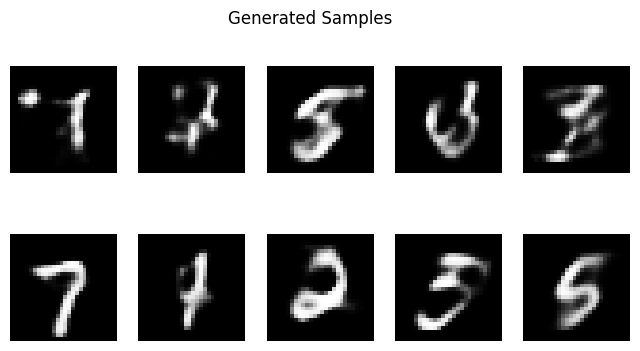

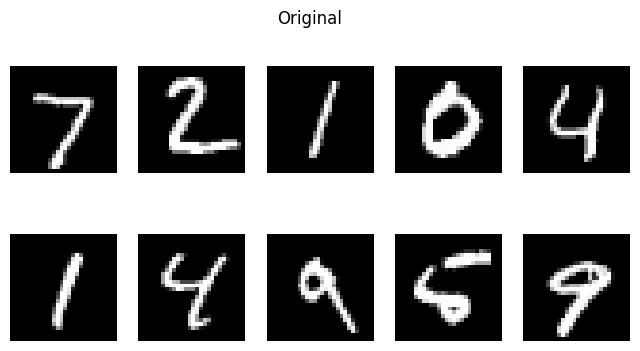

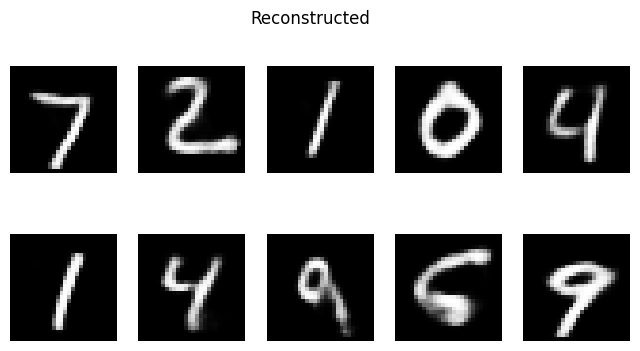

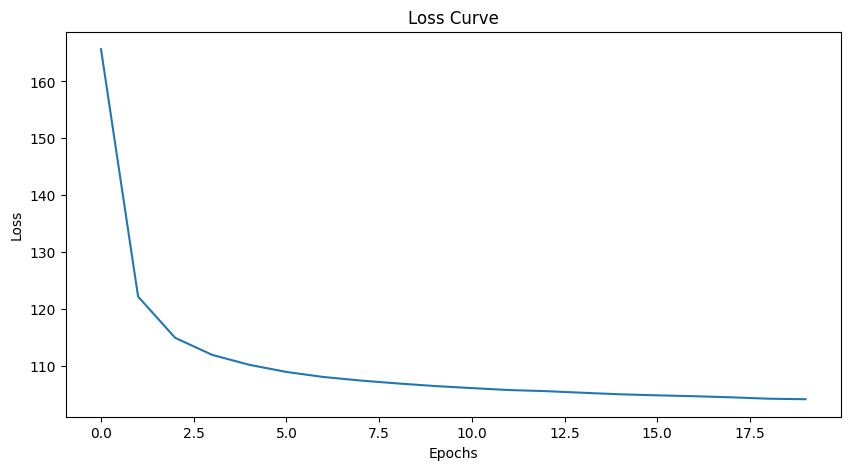

In [4]:
model.eval()

def show_img(imgs, title):
    imgs = imgs.cpu().detach().numpy()
    plt.figure(figsize=(8, 4))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(imgs[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

with torch.no_grad():
    z = torch.randn(10, 20).to(device)
    gen = model.d(z)
    show_img(gen, "Generated Samples")

data_iter = iter(test_l)
imgs, _ = next(data_iter)
imgs_flat = imgs.view(-1, 784).to(device)
with torch.no_grad():
    recon, _, _ = model(imgs_flat)
    show_img(imgs_flat[:10], "Original")
    show_img(recon[:10], "Reconstructed")

plt.figure(figsize=(10, 5))
plt.plot(train_loss)
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()